# Evictions in NYC - Explainer notebook

<b>Disclaimer</b>: Sadly the plotly plots and maps are not showing in the notebook when newly opened. Please look at the visualizations folder or download the GitHub project and run it locally!

## Table of contents

1. [Motivation](#motivation)
2. [Basic stats](#basicstats) \
    a. [Importing packages](#packages) \
    b. [Data cleaning/preprocessing and Exploratory Data Analysis](#datacleaning) 
3. [Data Analysis](#dataanalysis) \
    a. [Development over the years](#development) \
    b. [Marhals that performed most evictions](#marshals) \
    c. [Residential vs Commercial](#residentialvscommercial) \
    d. [Boroughs with most evictions](#boroughs) \
    e. [Map with evictions and hotspot areas](#evictionsMap) \
    f. [Insights about housing data](#housing) \
    g. [Insights about economic data](#economic) \
    h. [Insights about demographic data](#demographic) \
    i. [Interactive map with ACS data](#acsmap)
4. [Genre](#genre)
5. [Visualizations](#visualizations)
6. [Discussion](#discussion)
7. [Contributions](#contributions)
8. [References](#references)

<a id='motivation'></a>
## 1. Motivation

The main dataset we are using contains the registered evictions performed in New York City from 2017 until May 10th 2023. We decided to analyze this dataset because of our interest in social phenonemena and our excitement to discover patterns, development and connections to other factors. Evictions can be influenced by many elements and we were interested what impact social and economic situations have on this specific topic, as well as rent prices and living conditions. The American Community Survey (ACS) gathers this information with annual elicitations conducted by the U.S. Census Bureau. We are looking at the 5-year-estimates of the latest published years from 2017-2021.
With our analysis we want to provide insights into distributions of evictions in NYC and possible correlations between certain factors. The goal is to give an introduction to the topic and let the reader explore the informations further with interacitve plots afterwards.

<a id='basicstats'></a>
## 2. Basic stats

<a id='packages'></a>
### 2a. Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json 
import plotly.express as px
import plotly.graph_objs as go
import plotly
import os
import re
import calendar

from functools import reduce
from urllib import request
from datetime import datetime

In [2]:
# graph settings
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# ignore outputs regarding to missing fonts etc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# custom colorbar
c = plotly.colors.sample_colorscale(px.colors.sequential.Agsunset_r, samplepoints=20, colortype='tuple')
agsunset_hex = [] 
for row in c:
    agsunset_hex.append(matplotlib.colors.to_hex(row))
    
plot_color_1 = agsunset_hex[17]
plot_color_2 = agsunset_hex[7]

<a id='datacleaning'></a>
### 2b. Data cleaning, preprocessing and Exploratory Data Analysis

The dataset was inspected for missing values and we decided to exclude all records from the eviction dataset without an excact geographical location or the Neighborhood Tabulation Area (NTA), since our focus is on displaying these on a map and comparing it with the ACS data using the NTA's.
- total amount of records in the eviction data: 75443
- after removing all records without a location: 68207

There are some features in the dataset that are not interesting for our analysis so we remove them as well.
- total amount of columns: 20
- after removing uninteresting columns: 15

The ACS data contains one row for each NTA. Until 2020 the number of NTA's was 195, since then it is 262. The amount of features changes for the conducted year and specific category and ranges from 486 to 2730. We will focus only on a few limited topics that are interesting for our analysis like the average rent price. The total amount of features we are using is 57.

Because the NTA boundaries were changed we are using one json file for the 2010 NTA's and one for the 2020 NTA's. We also investigated if they contain all NTA's mentioned in our datasets.

In [4]:
# load the eviction dataset
df = pd.read_csv('data/Evictions.csv')

In [5]:
# turn dates into datetime
df['Executed Date'] = df['Executed Date'].apply(pd.to_datetime)
# add column with just the year
df['Year'] = df['Executed Date'].dt.year

In [6]:
# remove all rows that don't have a specific location
df = df.copy().dropna(subset=['NTA'])
# reomve columns that are not from interest for the analysis
df = df.drop(columns=['Eviction Apartment Number', 'Court Index Number', 'Docket Number ','Community Board', 'Council District', 'Census Tract'])

In [7]:
# checking for missing values
for column in df.columns:
    if df[column].isnull().sum() != 0:
        print(f'Missing values in {column}: {df[column].isnull().sum()}')

Missing values in BIN: 134
Missing values in BBL: 134


The rows with missing values in the columns above still have values for latitudes and longitudes so we are not removing them from the data.

In [8]:
# load data from directories and declare with variable name
myVars = vars()
rootFolder = 'data/'
def load_data(directory, data):
    for filename in os.listdir(rootFolder + directory):
        # filter out hidden files that start with .
        if not filename.startswith('.'):
            # assign name
            variable_name = "_".join(filename.split("_", 2)[:2])
            data.append(variable_name)
            myVars[variable_name] = pd.read_excel(rootFolder+directory+'/'+filename)
            # add a column with the conducted year
            year = int(variable_name.split("_")[1])
            myVars[variable_name]['Year'] = year
            # rename the geoname column to NTA
            myVars[variable_name] = myVars[variable_name].rename(columns={'GeoName': 'NTA', 'GeogName': 'NTA'})
    return data

In [9]:
# load all of the acs survey data
directories = ['housing_data', 'economic_data', 'social_data', 'demographic_data']
data = []
for directory in directories:
    data = load_data(directory, data)

In [10]:
# focus only on these columns in the acs data
hous_dict = {'Average Rent': 'MdGRE',
             'Total Housing Units': 'HU1E',
             'GRAPI <15': 'GRPIU15E' , 
             'GRAPI 15-19': 'GRPI15t19E', 
             'GRAPI 20-24': 'GRPI20t24E', 
             'GRAPI 25-29': 'GRPI25t29E', 
             'GRAPI 30-34': 'GRPI30t34E',
             'GRAPI >30': 'GRPI30plE',
             'GRAPI >35': 'GRPI35plE', 
             'GRAPI >50': 'GRPI50plE',
             'Year': 'Year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

econ_dict = {'Unemployed': 'CvLFUEm1E',
             'Civilian labor force': 'CvLF1E',
             'Average Household Income': 'MnHHIncE',
             'Income below Poverty': 'FamBwPvE', 
             'Total Households': 'HH2E',
             'Industry: Agriculture': 'AgFFHME', 
             'Industry: Construction': 'ConstctnE',
             'Industry: Manufacturing': 'MnfctrngE',
             'Industry: Wholesale trade': 'WhlsaleE',
             'Industry: Retail trade': 'RetailE',
             'Industry: Transportation': 'TrWHUtE',
             'Industry: Information': 'InfoE',
             'Industry: Finance and Insurance': 'FIREE',
             'Industry: Scientific, Management, Administrative Services': 'PrfSMgAWME',
             'Industry: Educational services, Health Care and Social Assistance': 'EdHlthCSAE',
             'Industry: Arts, Entertainment, Accommodation and Food Services': 'ArtEnRAFSE',
             'Industry: Other services': 'OthnotPAE',
             'Industry: Public administration': 'PubAdminE',
             'Year': 'Year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

soc_dict = {'Family Households': 'Fam1E',
            'Living with Children under 18': 'FamChU18E',
            'Non Family Households': 'NFam1E',
            'Living Alone': 'NFamAE', 
            'Male with Children under 18': 'MHnWChU18E',
            'Female with Children under 18': 'FHnHChU18E',
            'Average Household size': 'AvgHHSzE',
            'College Students': 'SE_ClgGScE',
            'Education: Less than High School': 'EA_LTHSGrE',
            'Education: High School': 'EA_HScGrdE',
            'Education: Bachelor or higher': 'EA_BchDHE',
            'Residence: More than 1 year': 'SmHsE',
            'Residence: Less than 1 year': 'DfHs1E',
            'Native American': 'NtvE',
            'Foreign Born':'Fb1E',
            'Year': 'Year',
            'NTA': 'NTA',
            'Borough': 'Borough'}

demo_dict = {'Total population': 'Pop_1E',
             'Median Age': 'MdAgeE',
             'Ethnicity: Hispanic/Latino': 'Hsp1E', 
             'Ethnicity: White': 'WtNHE', 
             'Ethnicity: Black or African American': 'BlNHE', 
             'Ethnicity: American Indian and Alaska Native': 'AIANNHE', 
             'Ethnicity: Asian': 'AsnNHE', 
             'Ethnicity: Native Hawaiian and Other Pacific Islander': 'NHPINHE', 
             'Ethnicity: Other race': 'OthNHE', 
             'Ethnicity: Two or more races': 'Rc2plNHE',
             'Year': 'Year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

acs_dict = hous_dict | econ_dict | soc_dict | demo_dict

In [11]:
# reduce the dataframes to only the above selected columns
# create combined dfs for each category

hous_combined = pd.DataFrame()
econ_combined = pd.DataFrame()
soc_combined = pd.DataFrame()
demo_combined = pd.DataFrame()

def reduce_dataframe(frame, columns):
    try:
        myVars[frame] = myVars[frame][columns]
    except Exception as e:
        exceptions = re.findall(r"'(.*?)'", str(e))
        newColumns = [x for x in columns if x not in exceptions]
        myVars[frame] = myVars[frame][newColumns]

for frame in data:
    if frame[:4] == 'hous':
        reduce_dataframe(frame, list(hous_dict.values()))
        hous_combined = pd.concat([hous_combined, myVars[frame]], axis=0)
    elif frame[:4] == 'econ':
        reduce_dataframe(frame, list(econ_dict.values()))
        econ_combined = pd.concat([econ_combined, myVars[frame]], axis=0)
    elif frame[:3] == 'soc':
        reduce_dataframe(frame, list(soc_dict.values()))
        soc_combined = pd.concat([soc_combined, myVars[frame]], axis=0)
    elif frame[:4] == 'demo':
        reduce_dataframe(frame, list(demo_dict.values()))
        demo_combined = pd.concat([demo_combined, myVars[frame]], axis=0)

In [12]:
# load the nta boundaries for 2010 NTA's
with open('data/NTA_map.geojson') as file:
    nta_json = json.load(file)

for i in list(range(len(nta_json['features']))):
    json_id = nta_json['features'][i]['properties']['ntaname']
    nta_json['features'][i]['id'] = json_id

In [13]:
# load the nta boundaries for 2020 NTA's
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
with request.urlopen(url) as response:
    nta_json_2020 = json.load(response)

for i in list(range(len(nta_json_2020['features']))):
    json_id = nta_json_2020['features'][i]['properties']['NTAName']
    nta_json_2020['features'][i]['id'] = json_id

In [14]:
# see what NTA's are not in json file
def check_nta_matches(nta_json, data):
    nta_list = []
    for i in list(range(len(nta_json['features']))):
        nta_list += [nta_json['features'][i]['id']]

    missing = 0
    same = 0
    for nta in data['NTA'].unique():
        if nta not in nta_list:
            missing += 1
            print('The following NTA is not in the json file:', nta)
        else: same += 1
    print('Same:',same)
    print('Missing:',missing)

In [15]:
# see if there are NTA geo boundaries missing for the eviction dataset
check_nta_matches(nta_json, df)

Same: 191
Missing: 0


In [16]:
# see if there are 2010 NTA geo boundaries missing for the acs data
check_nta_matches(nta_json, hous_2017)

The following NTA is not in the json file: Hudson Yards-Chelsea-Flat Iron-Union Square
Same: 194
Missing: 1


In [17]:
# see if there are 2020 NTA geo boundaries missing for the acs data
check_nta_matches(nta_json_2020, hous_2019)

Same: 262
Missing: 0


In [18]:
# replace name of NTA in acs survey data with name used in eviction dataset and json file
for file in data:
    myVars[file] = myVars[file].replace('Hudson Yards-Chelsea-Flat Iron-Union Square', 'Hudson Yards-Chelsea-Flatiron-Union Square')

<a id='dataanalysis'></a>
## 3. Data Analysis

In this chapter we are searching for patterns in the data, comparing it to the ACS data and show our findings in plots and maps. Main focus will be development in the past years, hotspot areas and insights about people living in NYC.

<a id='development'></a>
### 3a. Development over the years

In [ ]:
years = df.groupby(['Year'])['Year'].count().to_frame('Amount').reset_index()

fig = px.bar(years, y='Amount', x='Year')
fig.update_layout(title_text='Amount of evictions per year in NYC', 
                  title_x=0.5, 
                  font_family='Helvetica',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', tickmode='linear')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode="tozero")
fig.update_traces(textfont_size=12, 
                  textangle=0, 
                  textposition="outside",
                  width=0.6,
                  marker_color=plot_color_1)
#fig.add_traces(go.Scatter(x= years.Year, y=years.Amount, mode = 'lines', showlegend=False, hoverinfo='skip', line_color=plot_color_2))

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

The histogram above depicts the distribution of the number of evictions in the from Januray 1st 2017 until March 10th 2023. With a first glimpse, it can easily become evident that there is a significant decrease in 2020 and the following years. Research showed that this is related to the [Tentant Safe Harbor Act](https://hcr.ny.gov/covid-19-eviction-protections-tenants) to protect tenants that face financial issues due to Covid-19. This law was enacted from March 7th 2020 until Janunary 15th 2022.

Even though the moratorium ended in 2022 the number of evictions is still low compared to the years before Covid. In the next plot we are looking at this development more in detail.

In [ ]:
after_law = df.loc[(df.Year>=2022)&(df['Executed Date']<=datetime(2023,4,30))].groupby(['Year', df['Executed Date'].dt.month])['Executed Date'].count()
after_law = after_law.to_frame('Amount').reset_index()
after_law['Date'] = after_law['Executed Date'].apply(lambda m: calendar.month_abbr[m]) + '-' + after_law['Year'].astype(str).str[-2:]

fig = px.bar(after_law, y='Amount', x='Date')
fig.update_layout(title_text='Evictions since end of moratorium', 
                  title_x=0.5, 
                  font_family='Helvetica', 
                  plot_bgcolor= 'rgba(0, 0, 0, 0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', tickmode='linear', tickangle=-45)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False, marker_color=plot_color_1)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

We can see that the evictions are rising again but do not reach the level before covid. This could be related to the fact that courts are overwhelmed with the floods of legal requests for evictions from landlords. “There are some evictions going through, but there are many inherent delays with the court system resulting in evictions occurring but not at the pace or the level they were prior” ([Statement from lawyer in NYC](https://gothamist.com/news/nyc-eviction-rate-continues-to-rise-since-ban-was-lifted-as-homelessness-surges)).

What is also striking from the previous bar chart is the decrease in December. That's why the following plot is looking at patterns before Covid 2017-2019.

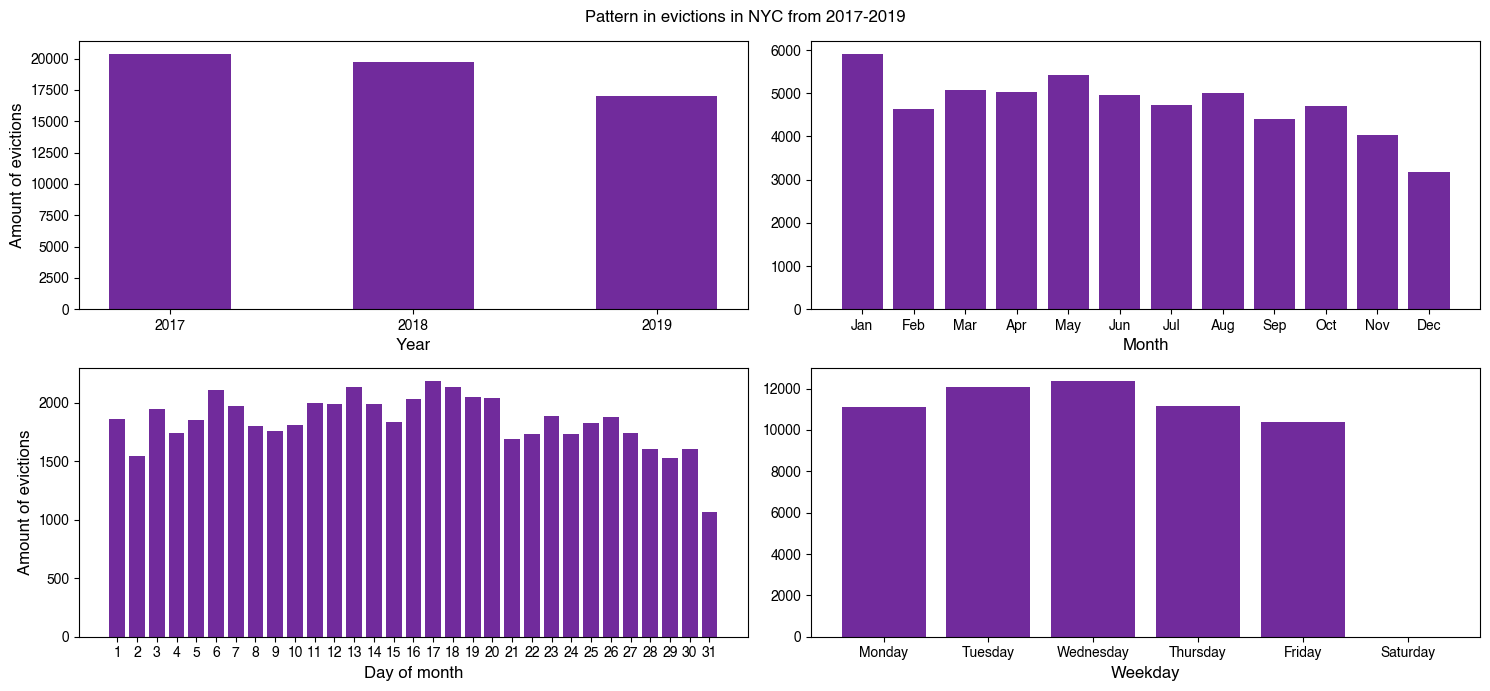

In [19]:
period_2017_2019 = df.loc[df['Executed Date']<=datetime(2020,1,1)]

fig, axs = plt.subplots(2,2)

years = period_2017_2019.groupby([df['Executed Date'].dt.year])['Executed Date'].count().to_frame('Amount').reset_index()
months = period_2017_2019.groupby([df['Executed Date'].dt.month])['Executed Date'].count().to_frame('Amount').reset_index()
days = period_2017_2019.groupby([df['Executed Date'].dt.day])['Executed Date'].count().to_frame('Amount').reset_index()
weekdays = period_2017_2019.groupby([df['Executed Date'].dt.weekday])['Executed Date'].count().to_frame('Amount').reset_index()

plt.subplot(2,2,1)
plt.bar(years['Executed Date'], years['Amount'], color=plot_color_1, width=0.5)
plt.xticks(range(2017,2020))
plt.xlabel('Year')
plt.ylabel('Amount of evictions')

plt.subplot(2,2,2)
plt.bar(months['Executed Date'], months['Amount'], color=plot_color_1)
plt.xlabel('Month')
plt.xticks(range(1,13),labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.subplot(2,2,3)
plt.bar(days['Executed Date'], days['Amount'], color=plot_color_1)
plt.xlabel('Day of month')
plt.xticks(range(1,32))
plt.ylabel('Amount of evictions')

plt.subplot(2,2,4)
plt.bar(weekdays['Executed Date'], weekdays['Amount'], color=plot_color_1)
plt.xlabel('Weekday')
plt.xticks(range(6),labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

plt.suptitle('Pattern in evictions in NYC from 2017-2019')
plt.tight_layout()
plt.show()

From the previous plots it shows that there are lower amounts of evictions especially in December. Some countries have winter moratoriums to protect people from being homeless in the cold months of the year, but there is now law like this in NYC. Another reason could be the holiday season which would also explain the high amount in January, since some court cases might be held off until the new year. As a result, there may be a backlog of eviction proceedings that are initiated in January, leading to higher eviction rates.

We can see that some marshals are also working on Saturday, even though the occurences are very small. You can see the four evictions that happened on a Saturday 2017-2019 below.

In [20]:
df[df['Executed Date'].dt.weekday == 5]

,Eviction Address,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,BIN,BBL,NTA,Year
6411,2710 VALENTINE AVE,2018-04-14,Maxine,Chevlowe,Residential,BRONX,10458,Not an Ejectment,Possession,40.866738,-73.892410,2017005.0,2.033000e+09,Bedford Park-Fordham North,2018
19047,2695 BRIGGS AVENUE,2018-04-14,Maxine,Chevlowe,Residential,BRONX,10458,Not an Ejectment,Possession,40.866140,-73.891854,2017014.0,2.033000e+09,Bedford Park-Fordham North,2018
32969,2555 BAINBRIDGE AVENUE,2017-06-17,Thomas,Bia,Residential,BRONX,10458,Not an Ejectment,Possession,40.862990,-73.893009,2016813.0,2.032930e+09,Bedford Park-Fordham North,2017
69464,1500 GRAND CONCOURSE,2018-04-14,Maxine,Chevlowe,Residential,BRONX,10457,Not an Ejectment,Possession,40.841345,-73.912549,2007849.0,2.028210e+09,East Concourse-Concourse Village,2018


<a id='marshals'></a>
### 3b. Marhals that performed most evictions

In [21]:
df['Marshal Full Name'] = df['Marshal First Name'] + ' ' + df['Marshal Last Name']

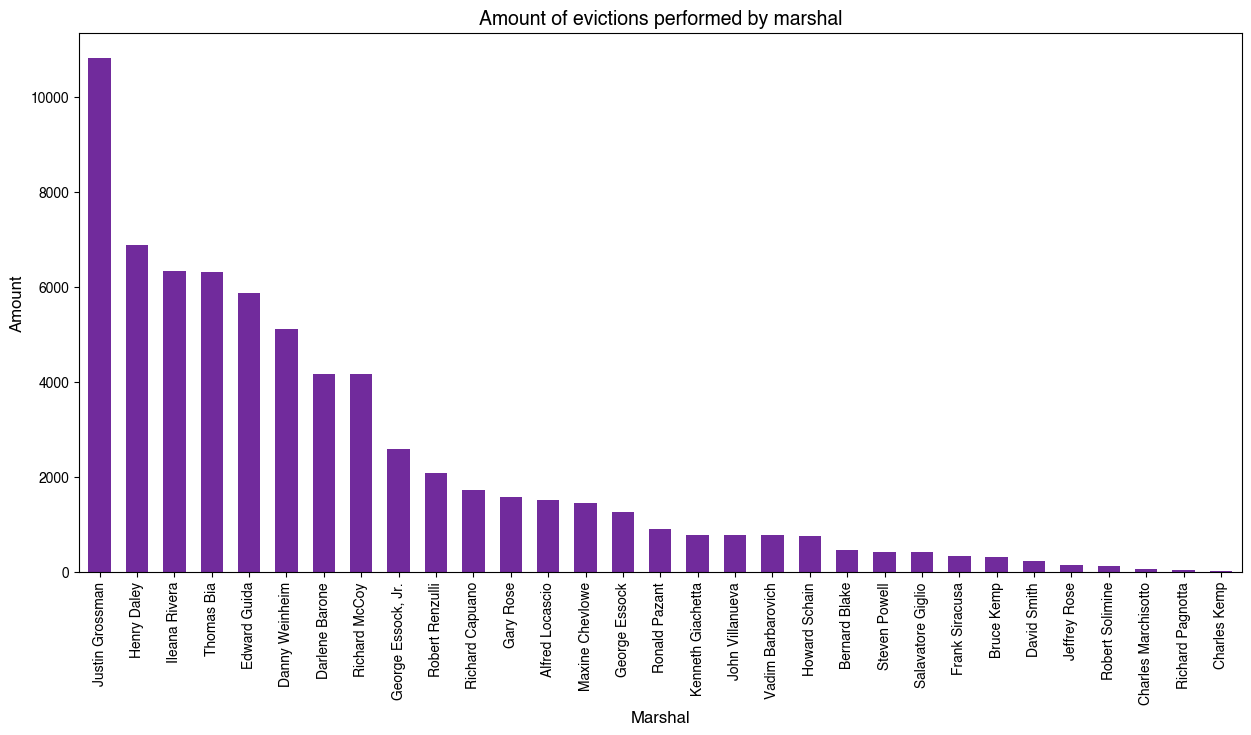

In [22]:
df.groupby(df['Marshal Full Name'])['Executed Date'].count() \
    .sort_values(ascending=False) \
    .plot(kind='bar', color=plot_color_1, width=0.6)
plt.title('Amount of evictions performed by marshal')
plt.xlabel('Marshal')
plt.ylabel('Amount')
plt.xticks(rotation=90)
plt.show()

Another interesting information that we derived from the initial dataset is the list of marshals who performed the evictions over the years. The information someone could obtain from this plot is that there is a relatively small number of officers specializing in evictions for such a big city as New York while it is even more interesting to see that one police marshal stands out especially.

<a id='residentialvscommercial'></a>
### 3c. Residential vs Commercial

In [ ]:
rescom = df.groupby(['Residential/Commercial'])['Residential/Commercial'].count().to_frame('Amount').reset_index()

fig = px.pie(rescom, values = 'Amount', #hole = 0.4,
             names = 'Residential/Commercial',
             color_discrete_sequence=px.colors.sequential.Agsunset,
             title = 'Residential vs Commercial Evictions'
             )

fig.update_traces(title_font = dict(size=25,family='Helvetica'),
                  hoverinfo='label',
                  textinfo='percent', 
                  textfont_size=14,
                  hovertemplate = 'Type: %{label}'
)

fig.update_layout(title_x=0.5)
fig.update_layout(margin=dict(l=300, r=300, t=90, b=0))
fig.show()

From the piechart it can be seen that the majority of the evictions corresponds to residential buildings with a percentage of 93%. Commercial tenants may be companies and firms or also storages. 

<a id='boroughs'></a>
### 3d. Boroughs with most evictions

In [ ]:
merge_boroughs = pd.merge(df[['NTA', 'BOROUGH']], hous_2017, left_on=['NTA'], right_on=['NTA'], how='left')
units = merge_boroughs.groupby(['NTA'])['HU1E'].mean().to_frame('units').reset_index()
boroughs = df.groupby(['NTA','BOROUGH'])['BOROUGH'].count().to_frame('amount').reset_index()

boroughs_plot = pd.merge(boroughs, units, left_on=['NTA'], right_on=['NTA'], how='right')    
boroughs_plot = boroughs_plot.groupby(['BOROUGH'])[['amount', 'units']].sum().reset_index()

boroughs_plot['ratio'] = boroughs_plot.amount / boroughs_plot.units
boroughs_plot['color'] = agsunset_hex[::4]

fig = px.pie(boroughs_plot, values = 'ratio', hole = 0.4,
             names = 'BOROUGH',
             color_discrete_sequence=px.colors.sequential.Agsunset,
             title = 'Ratio of evictions in boroughs',
             height=300
             )

fig.update_traces(title_font = dict(size=25,family='Helvetica'),
                  hoverinfo='label',
                  textinfo='percent', 
                  textfont_size=14,
                  hovertemplate = 'Borough: %{label}'
)

fig.update_layout(title_x=0.5, font_family='Helvetica',)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

At this point, the ratio of evictions in the boroughs was plotted in order to get a first view on the hotspot areas. The borough plot reveals that Bronx stands out with the highest number of recorded evictions followed by Brooklyn. This information would later be enhanced by plotting the Neighborhood Tabulation Areas (NTAs) in an interactive geo map to investigate further which areas could be considered as eviction "hotspots". 

<a id='evictionsMap'></a>
### 3e. Map with evictions and hotspot areas

In [23]:
# prepare data for map
map_data = df.groupby([df.Year,'NTA'])['NTA'].count()
map_data = map_data.rename('Evictions').to_frame().reset_index()

In [24]:
# buildings with the most evictions
df[df['Year']==2017].groupby(['BIN'])['BIN'].count().sort_values(ascending=False).iloc[0:5]

BIN
1080331.0    24
3000000.0    21
2113628.0    21
2000000.0    20
4298968.0    19
Name: BIN, dtype: int64

The Building Identification Number (BIN) is a unique number for each building in NYC. At first glance it seems like a lot of evictions happened in the building with the number 3000000. But the addresses differ which reveals human noise. However, for the buildings where the location is the same it is interesting to investigate further.  

The building with most evictions (BIN 1080331) for example a storage which explains the location in Manhatten on the map below.

In [25]:
# keeping buildings for map with amount higher or equal to 10
buildings = df.groupby(['BIN', 'Latitude', 'Longitude', 'Year'])['BIN'].count().sort_values(ascending=False).to_frame('Amount').reset_index()
buildings_dots = buildings[buildings.Amount >= 10]

In [ ]:
zmin = map_data['Evictions'].min()
zmax = map_data['Evictions'].max()

# map with NTA's
fig = px.choropleth_mapbox(map_data, geojson=nta_json, locations='NTA', color='Evictions',
                        color_continuous_scale='agsunset_r',
                        mapbox_style="carto-positron",
                        zoom=9.1, center = {"lat": 40.72, "lon": -73.93},
                        animation_frame='Year',
                        #width=950,
                        #height=600,
                        hover_data={'Year':False}
                        )
fig.update_traces(marker_line_width=0.5, 
                  marker_opacity=0.8
                 )

# dots with hotspot buildings
fig2 = px.scatter_mapbox(buildings_dots, lat="Latitude", lon="Longitude",
            animation_frame = 'Year',
            size="Amount", 
            color_discrete_sequence = ['black'],
            size_max=7,
            hover_data={'Year':False, 'Latitude':False, 'Longitude':False}
            )

fig.add_trace(fig2.data[0])
for i in range(len(fig.frames)):
    if i >= len(fig2.frames):
        emptydata = fig2.frames[0].data[0]
        emptydata['lat'] = []
        emptydata['lon'] = []
        fig.frames[i].data += (emptydata,)
    else:
        fig.frames[i].data += (fig2.frames[i].data[0],)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                 coloraxis=dict(
                    cmin=zmin,
                    cmax=zmax
                ))
fig.show()

The last information derived from our initial dataset is an interactive map of the 195 listed neighborhoods (NTAs) with the occurences of evictions spanned over the years. The black dots indicate buidlings with 10 or more evictions for that year.

You can also see the occurences as heatmap below.

In [ ]:
zmin = buildings['Amount'].min()
zmax = buildings['Amount'].max()

# keep years in right order
buildings['Year'] = buildings['Year'].astype(int) 
buildings = buildings.sort_values('Year')

# heatmap
fig = px.density_mapbox(buildings, lat = 'Latitude', lon = 'Longitude', z = 'Amount',
                        radius = 6,
                        center = {"lat": 40.72, "lon": -73.93},
                        zoom=9.1,
                        mapbox_style = 'carto-positron',
                        color_continuous_scale='agsunset',
                        animation_frame='Year',
                        width=950,
                        height=600,
                        hover_data={'Year':False, 'Latitude':False, 'Longitude':False, 'BIN':True})

# keep legend value range the same
fig.update_layout(
    coloraxis=dict(
        cmin=zmin,
        cmax=zmax
    )
)

fig.show()

Analyzing the above, it was judged necessary to incorporate more information about the specified areas with high amount of evictions. Thus, we are using economic, social, housing and demographic data of the NTA's in the following.

<a id='housing'></a>
### 3f. Insights about housing data

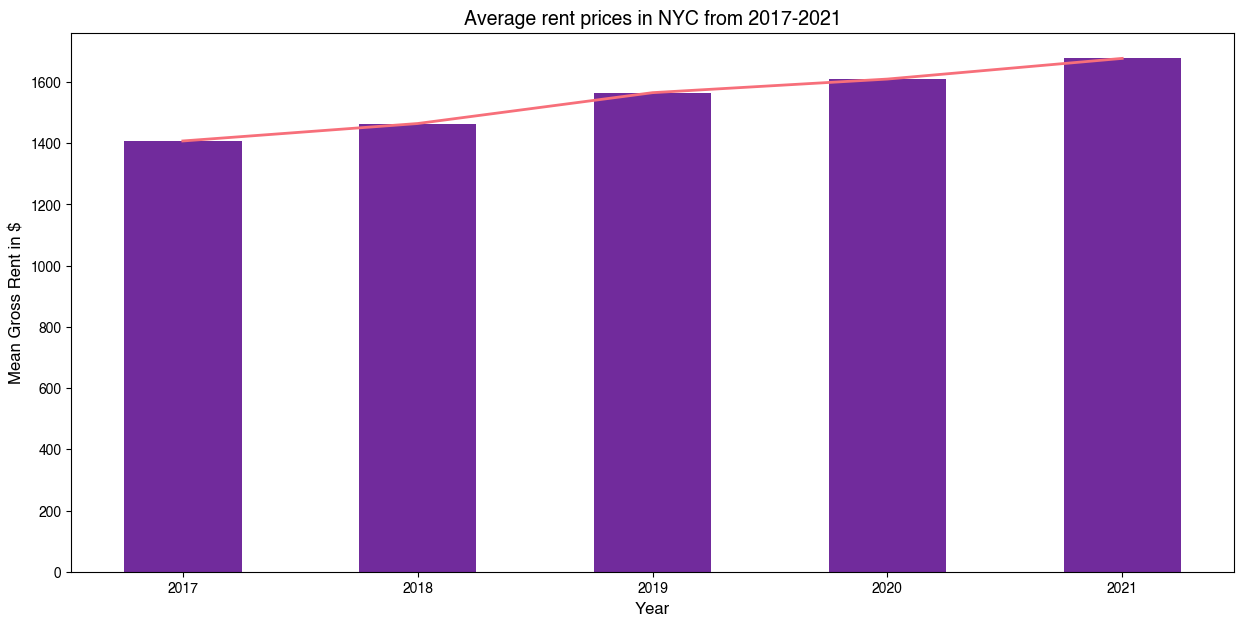

In [26]:
df_rent = hous_combined.groupby(['Year'])['MdGRE'].mean()
plt.bar(df_rent.index, df_rent, width=0.5, color=plot_color_1)
plt.plot(df_rent, color=plot_color_2, linewidth=2)
plt.ylabel('Mean Gross Rent in $')
plt.xlabel('Year')
plt.title('Average rent prices in NYC from 2017-2021')
plt.show()

In [27]:
# average rent increase
rent2017 = hous_2017['MdGRE'].mean()
rent2019 = hous_2019['MdGRE'].mean()
rent2021 = hous_2021['MdGRE'].mean()
print(f"Increase of {round(rent2021/rent2017-1, 3)*100}% in average rent from 2017 to 2021.")

Increase of 19.2% in average rent from 2017 to 2021.


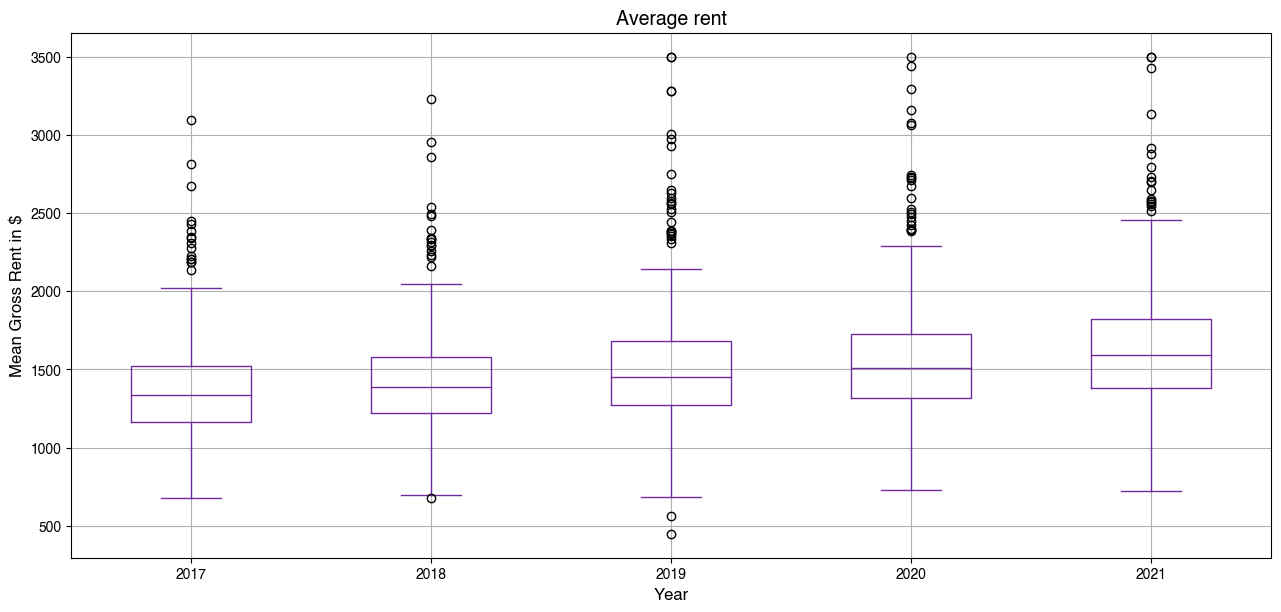

In [28]:
hous_combined.boxplot(column=['MdGRE'], by='Year', color=plot_color_1)
plt.xlabel('Year')
plt.ylabel('Mean Gross Rent in $')
plt.title('Average rent')
plt.suptitle('')
plt.show()

The first thing someone has to search for in order to analyze evictions, is the respective rent prices as well as the household income spanned over the examined period. In this regard, we have plotted the Mean Gross Rent over the years in the figures above. It can be seen that Rent prices are steadily increasing over the years, something that does not come along with the decreasing occurences in evictions in 2017-2019. For this reason, the mean gross rent should be compared with the respective household income (next chapter) in order to better justify the results.

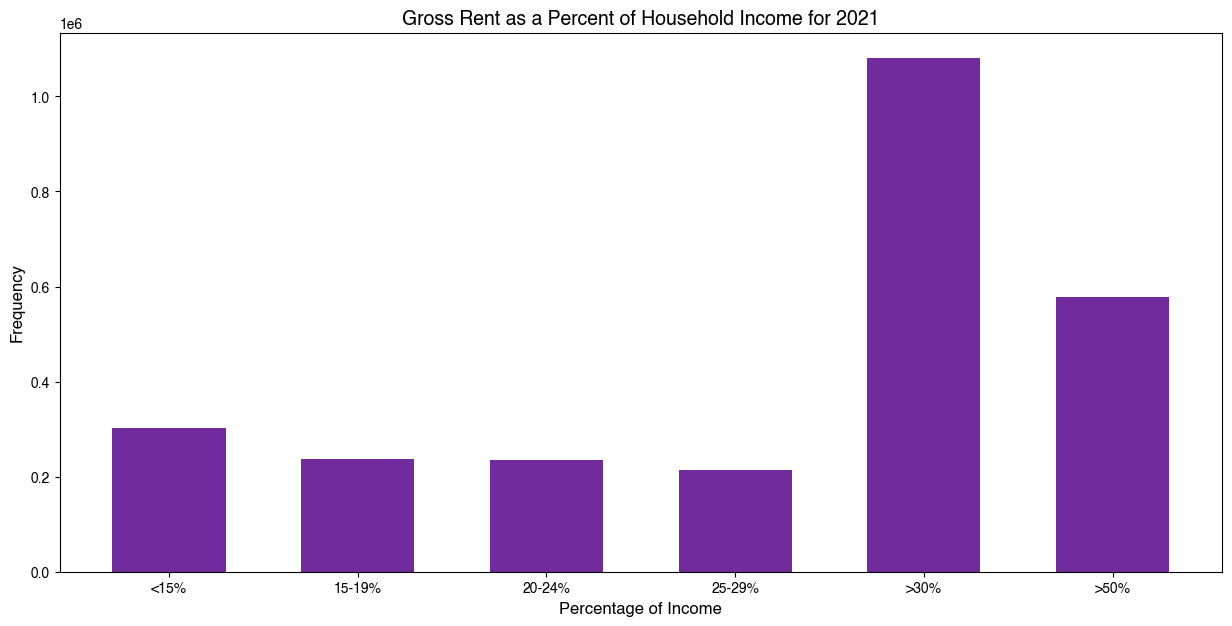

In [29]:
df_GRAPI = hous_2021[['GRPIU15E' , 'GRPI15t19E' , 'GRPI20t24E' , 'GRPI25t29E' , 'GRPI30plE' , 'GRPI50plE']].sum()
plt.bar(df_GRAPI.index, df_GRAPI, width=0.6, color=plot_color_1)
plt.xticks(ticks=range(len(df_GRAPI)), labels=['<15%', '15-19%', '20-24%','25-29%','>30%','>50%'])
plt.title('Gross Rent as a Percent of Household Income for 2021')
plt.xlabel('Percentage of Income')
plt.ylabel('Frequency')
plt.show()

Before analyzing the income, it was considered relevant to check also the percentage of the salary that people spend on their rent. Since the values of the ACS data do not differ significantly over the years, we decided to plot the file from 2021 since it is the newest one and is a 5-year-estimate, so it contains information from 2016-2021. It can be seen that for the majority of the population, monthly rent accounts for more than 30% of households monthly income and a large amount more than 50%.

<a id='economic'></a>
### 3g. Insigths about economic data

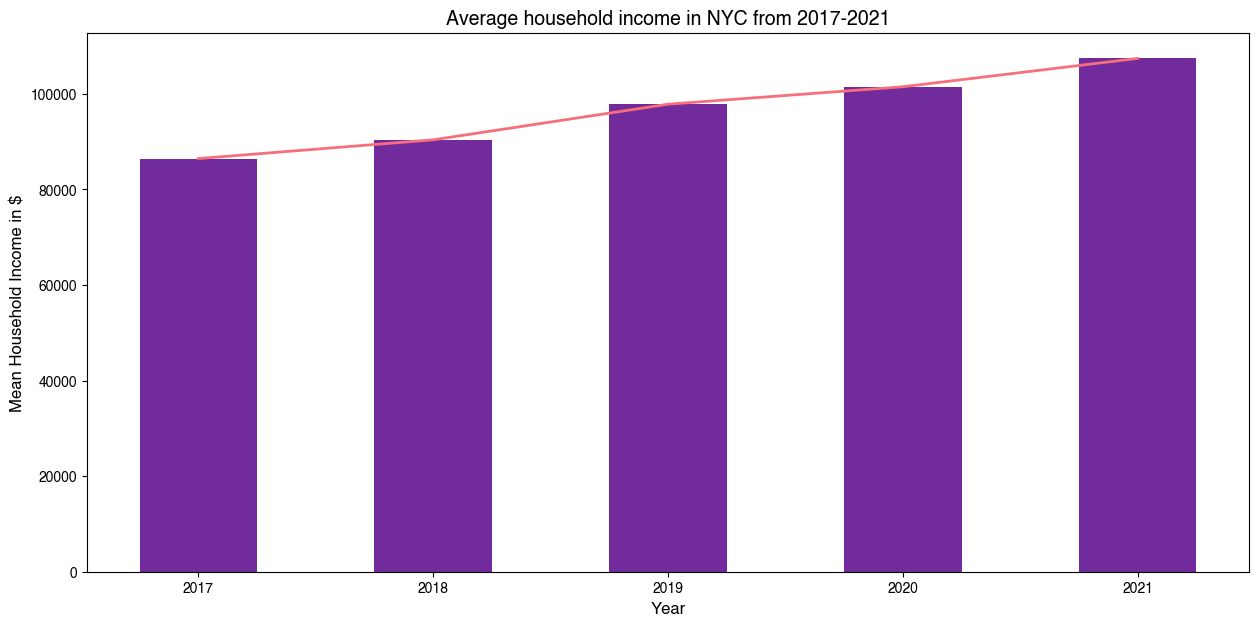

In [30]:
df_income = econ_combined.groupby(['Year'])['MnHHIncE'].mean()
plt.bar(df_income.index, df_income, width=0.5, color=plot_color_1)
plt.plot(df_income, color=plot_color_2, linewidth=2)
plt.ylabel('Mean Household Income in $')
plt.xlabel('Year')
plt.title('Average household income in NYC from 2017-2021')
plt.show()

In [31]:
# average household income increase
income2017 = econ_2017['MnHHIncE'].mean()
income2019 = econ_2019['MnHHIncE'].mean()
income2021 = econ_2021['MnHHIncE'].mean()
print(f"Increase of {round(income2021/income2017-1, 3)*100}% in average household income from 2017 to 2021.")

Increase of 24.2% in average household income from 2017 to 2021.


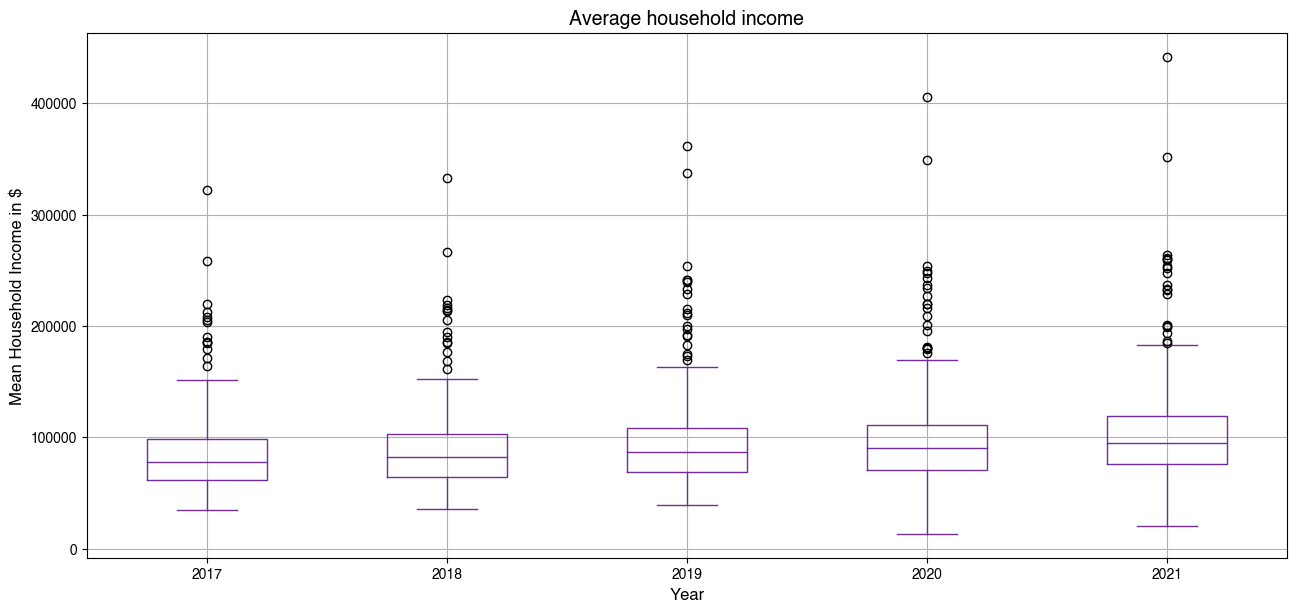

In [32]:
econ_combined.boxplot(column=['MnHHIncE'], by='Year', color=plot_color_1)
plt.xlabel('Year')
plt.ylabel('Mean Household Income in $')
plt.title('Average household income')
plt.suptitle('')
plt.show()

In our search for the annual household income, we found out that its mean value is increasing over the years. These findings come along with the rent prices that are increasing as well, and they also justify the decreasing occurences in evictions. A reasonable interpretation of the above two plots would be that since the income increases, the rent prices go up and thus a steady economic situation is retained with people paying their rent.

In [ ]:
df_industries = econ_2021.groupby(['Borough'])[['AgFFHME', 'ConstctnE','MnfctrngE','WhlsaleE','RetailE','TrWHUtE','InfoE','FIREE','PrfSMgAWME','EdHlthCSAE','ArtEnRAFSE','OthnotPAE','PubAdminE']].sum()
df_industries.rename(columns = {'AgFFHME':'Agriculture', 'ConstctnE':'Construction', 'MnfctrngE':'Manufacturing', 'WhlsaleE':'Wholesale trade', 'RetailE':'Retail trade', 'TrWHUtE':'Transportation', 'InfoE':'Information', 'FIREE':'Finance and insurance','PrfSMgAWME':'Scientific, management','EdHlthCSAE':'Educational services','ArtEnRAFSE':'Arts and entertainment','OthnotPAE':'Other services','PubAdminE':'Public administration'}, inplace = True)
df_industries['sum'] = df_industries.sum(axis=1)
df_industries_ratio = df_industries.div(df_industries['sum'], axis=0)
df_industries_ratio = df_industries_ratio.drop(['sum'], axis=1)

# prepare data
industries = df_industries_ratio.columns.tolist()
boroughs = df_industries_ratio.index.tolist()

# colors
c_1 = plotly.colors.sample_colorscale(px.colors.sequential.Agsunset_r, samplepoints=len(industries), colortype='tuple')
agsunset_hex_1 = [matplotlib.colors.to_hex(row) for row in c_1]

fig = go.Figure()

for i, industry in enumerate(industries):
    fig.add_trace(go.Bar(
        name=industry,
        x=boroughs,
        y=df_industries_ratio[industry],
        marker_color=agsunset_hex_1[i]
    ))

# update layout for stacked bar
fig.update_layout(
    barmode='stack',
    title='Distribution of people in NYC working in different industries per borough',
    title_x=0.5,
    xaxis_title='Borough',
    yaxis_title='Percentage of workforce',
    yaxis_tickformat='.0%',
    xaxis=dict(tickangle=0, showline=True, linecolor='black', linewidth=1),
    yaxis=dict(showline=True, linecolor='black', linewidth=1),
    font=dict(family='Helvetica'),
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        title='Industry',
        traceorder='reversed'
    ),
    hoverlabel=dict(
        namelength=-1, # show full trace name (no truncation)
        font_size=14, 
        font_family="Helvetica",
        align="left"
    ),
    margin={"r":0,"t":40,"l":0,"b":0},
    #height=600,
    #width=900
)

fig.show()

Another instersting aspect that can enrich our research on evictions, is the distribution of diferrent professions among the civilian labor force of the city. Thus, we created the above plot that distinguishes the ratio of professions compared to the total population of each borough. It can be seen that Educational services (including healthcare and social assistance) is the field in which most people are employed with Bronx standing out with the highest ratio. Moreover, it is clear that Manhattan possesses the highest ratio in Finance and insurance recognized as a financial district worldwide while scientific and management fields are also dominating in Manhattan. Comparing the above with the eviction occurrences among the Boroughs, it can be inferred that the low ratio of evictions in Manhattan can be linked to the fact that a lot of people in this Borough are working in finance which is a highly paid field. 

In [ ]:
amount_unemployed = econ_combined.groupby(['Year'])['CvLFUEm1E'].sum()
amount_labor_force = econ_combined.groupby(['Year'])['CvLF1E'].sum()
unemployed_ratio = amount_unemployed / amount_labor_force * 100
unemployed_ratio = unemployed_ratio.to_frame('Unemployment Rate in %').reset_index()

fig = px.bar(unemployed_ratio, y='Unemployment Rate in %', x='Year')
fig.update_layout(title_text='Unemployment Rate in NYC from 2017-2021', 
                  title_x=0.5, 
                  font_family='Helvetica',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', tickmode='linear')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_traces(textfont_size=12, 
                  textangle=0, 
                  textposition="outside",
                  width=0.6,
                  marker_color=plot_color_1)
#fig.add_traces(go.Scatter(x=unemployed_ratio.Year, y=unemployed_ratio['Unemployment Rate in %'], mode = 'lines', showlegend=False, hoverinfo='skip', line_color=plot_color_2))

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

At this point, it makes sense to relate eviction incidents with the unemployment status of the city. In particular, from the supplementary dataset, the total unemployment percentage rate was calculated and plotted against the examined period. It is evident that unemployment in New York City is decreasing until 2019, while the outburst of COVID-19 in 2020 boosts the rates. The decrease in unemployment also justifies the downward trend of the evictions in the respective years.

<a id='demographic'></a>
### 3g. Insights about demographic data

Since evictions is a highly controversial phenomenon with many people in favor and against it, we want to check whether there is any correlation with targeted ethnicity groups. For this reason, we retrived information about ethnicity groups in the boroughs and tried to relate it with the corresponding eviction occurrences in these areas.

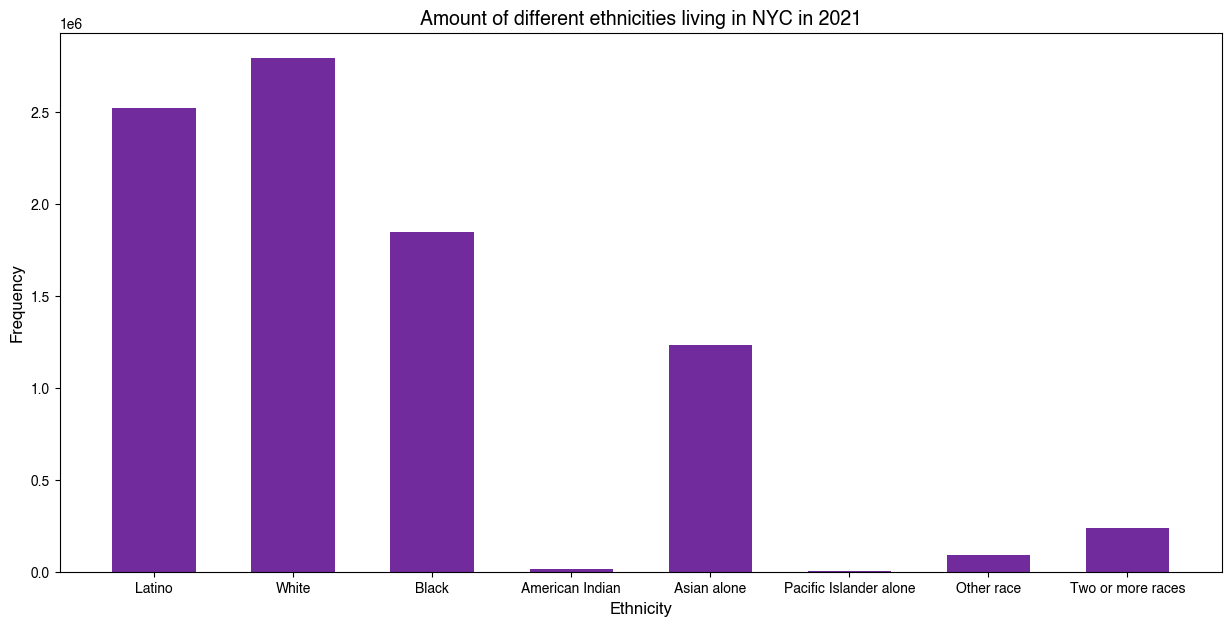

In [33]:
df_ethnicity = demo_2021[["Hsp1E", "WtNHE", "BlNHE", "AIANNHE", "AsnNHE", "NHPINHE", "OthNHE", "Rc2plNHE"]]
df_ethnicity.rename(columns = {'Hsp1E':'Latino', 'WtNHE':'White', 'BlNHE':'Black', 'AIANNHE':'American Indian', 'AsnNHE':'Asian alone', 'NHPINHE':'Pacific Islander alone', 'OthNHE':'Other race', 'Rc2plNHE':'Two or more races'}, inplace = True)

df_ethnicity_plot = df_ethnicity.sum()
plt.bar(df_ethnicity_plot.index, df_ethnicity_plot, width=0.6, color=plot_color_1)
plt.title('Amount of different ethnicities living in NYC in 2021')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.show()

In the above plot, you can see the distribution of ethnicities in the city of New York. It looks like the majority of the population is White people, Latino and then followed by Black people.

In [ ]:
# prep data
df_ethnicity = demo_2021.groupby(["Borough"])[["Hsp1E", "WtNHE", "BlNHE", "AIANNHE", "AsnNHE", "NHPINHE", "OthNHE", "Rc2plNHE"]].sum()
df_ethnicity.rename(columns={
    'Hsp1E': 'Latino',
    'WtNHE': 'White',
    'BlNHE': 'Black',
    'AIANNHE': 'American Indian',
    'AsnNHE': 'Asian alone',
    'NHPINHE': 'Pacific Islander alone',
    'OthNHE': 'Other race',
    'Rc2plNHE': 'Two or more races'
}, inplace=True)
df_ethnicity['sum'] = df_ethnicity.sum(axis=1)
df_ethnicities_ratio = df_ethnicity.div(df_ethnicity['sum'], axis=0).drop(columns=['sum'])

# color mapping
c_1 = plotly.colors.sample_colorscale(px.colors.sequential.Agsunset_r, samplepoints=len(df_ethnicities_ratio.T), colortype='tuple')
agsunset_hex_1 = [matplotlib.colors.to_hex(c) for c in c_1]
fig = go.Figure()

# stacked bar chart
fig = go.Figure()

for i, column in enumerate(df_ethnicities_ratio.columns):
    fig.add_trace(go.Bar(
        x=df_ethnicities_ratio.index,
        y=df_ethnicities_ratio[column],
        name=column,
        marker_color=agsunset_hex_1[i]
    ))

# layout updates
fig.update_layout(
    barmode='stack',
    title='Amount of people belonging to a certain ethnicity living in the boroughs',
    title_x=0.5,
    xaxis=dict(title='Borough', showline=True, linecolor='black', linewidth=1),
    yaxis=dict(title='Proportion of Population (%)', tickformat='.0%', showline=True, linecolor='black', linewidth=1),
    font_family='Helvetica',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(title='Ethnicity'),
    hoverlabel=dict(
        namelength=-1,
        font_size=13,
        font_family='Helvetica',
        align="left"
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
    #height=600,
    #width=900
)

fig.show()

Based on the above plot, we observe the Bronx Borough is comprised mostly of Latinos and African Americans while White people form the minority of the borough. In contrast, Brooklyn is more or less, evenly distributed among White, Black and Latino ethnicities. Finally, Asian people seem to mostly reside in Queens, while is is evident that Staten Island Borough is mostly comprised of white ethnicities. Trying to correlate ethnicity groups with evictions, it can be noticed that the Bronx borough that has the highest number of evictions, is comprised of Latino and Black people. However, in order to be able to have a clearer and correct assumption on this, more investegation had to follow.

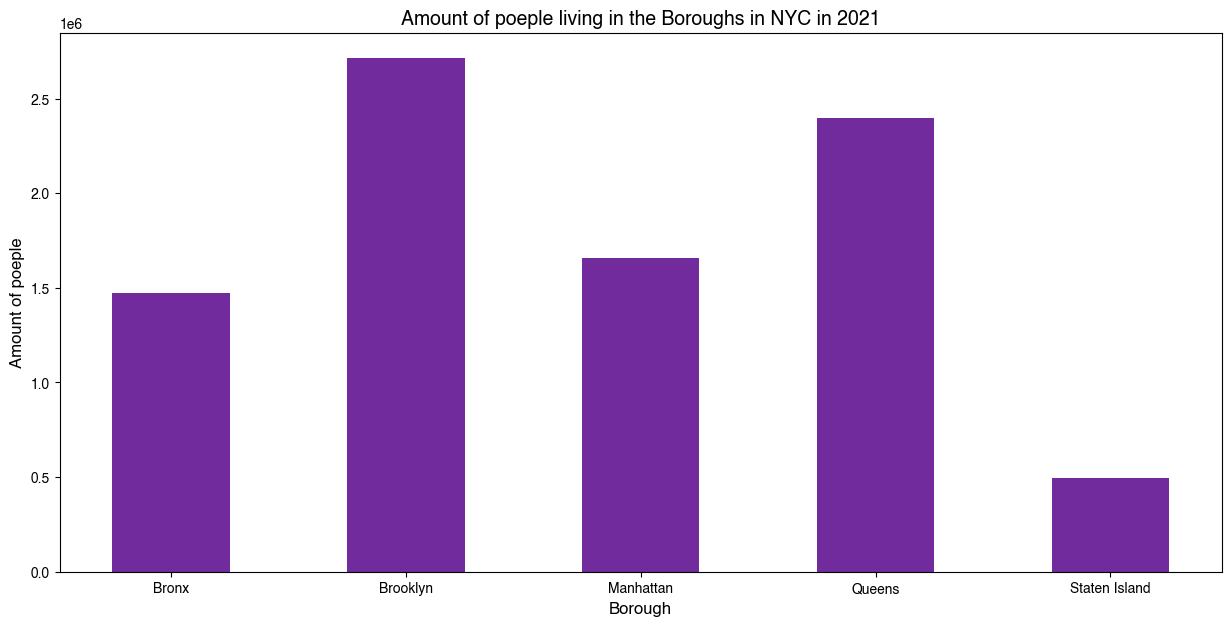

In [34]:
df_borough_pop = demo_2021.groupby("Borough")['Pop_1E'].sum()
plt.bar(df_borough_pop.index, df_borough_pop, width=0.5, color=plot_color_1)
plt.xlabel('Borough')
plt.ylabel('Amount of poeple')
plt.title('Amount of poeple living in the Boroughs in NYC in 2021')
plt.show()

From our initial dataset, we identified that Bronx is the borough with the most evictions. However, in order to be able to better intrepret that information, we decided to plot the respective populations on all the Boroughs. As you can see in the below plot, Brooklyn and Queens are the most populated boroughs while Bronx comes in 4th place. From this results, it makes sense to focus on the Bronx districts and its "characteristics" since the eviction cases are not proportional to the population.

<a id='acsmap'></a>
### 3i. Interactive map with ACS data

In [35]:
# merge all acs together
merge = reduce(lambda left,right: pd.merge(left,right,on=['NTA', 'Year', 'Borough'],how='outer'), [hous_2018, econ_2018, soc_2018, demo_2018])

In [ ]:
fig = go.Figure(go.Choroplethmapbox(
        z=merge['MdGRE'], 
        geojson=nta_json, 
        locations=merge['NTA'],
        text = merge['NTA'],
        hovertemplate = '<b>NTA</b>: <b>%{text}</b>'+'<br><b>Amount</b>: %{z}<br><extra></extra>',
        marker_line_width=0.5, 
        marker_opacity=0.6,
        colorscale='agsunset_r'))

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    autosize=True,
    hovermode='closest',
    showlegend=True,
    mapbox=dict(
        bearing=0,
        center={"lat": 40.72, "lon": -73.93},
        pitch=0,
        zoom=9.1,
        style="carto-positron"
        )) 

buttons = []
features = acs_dict.copy()
[features.pop(key) for key in ['Year', 'NTA', 'Borough', 'GRAPI >30']]
for k, v in features.items():
    button_dict = {'method': 'update',
                  'label': k,
                  'args': [{'z': [merge[v]]}]}
    buttons.append(button_dict)
    
fig.update_layout(updatemenus=[dict(active=0,
                                    buttons=buttons,
                                    x = 0,
                                    xanchor = 'left',
                                    y = 1.1,
                                    yanchor = 'top',
                                    pad={"r": 10, "t": 10})])

fig.show()

The interactive map above shows different features that we are considering as relevant for evictions. Feel free to investigate yourself and click through the drop-down menu.

<a id='genre'></a>
## 4. Genre

For our story, we used magazine as genre. The reason why we decided to use this genre is due to the fact that magazines can captivate visuals. For specifically, magazines are popular for their ability to handle layouts, with graphics and photographies. This can draw the attention of the readers and make them focus on the details. Also, magazines can integrate multiple formats in their pages which provide different aspects and perspectives of the data, making them appealing for the readers. This genre is also ideal for an author-driven style to give an introduction to the story but let the reader explore the visualizations.

From the Visual Narrative we used Consistent Visual Platfrom, Progress Bar and Feature Distinctions. The reason why we used Consistent Visual Platfrom is beacuse it is easier for the reader to follow the same colour layout while reading the data story. Since our main goal is evictions that took place in a specific period (2017-2023) we are using a Progress Bar to illustrate the evolution throughout these years. Finally, we focus on specific features of all the dataset which justifies our choice for Feature Distinctions.  

From the Narrative Structure we used linear ordering since the magazine is author-driven but gives the possibility to the user to explore the visualizations. Moreover, Hover Highlighting and Filtering/Selection/Search are used for the interactive plots and maps. Finally, regarding messaging, we used Captions and Annotations to make it easier for the reader to understand the figures. Accompanying Articles support our findings and the Introductory Text was used to give a brief explanation to the topic and datasets. 

<a id='visualizations'></a>
## 5. Visualizations

The visualizations that we chose for our project are bar charts, donut/pie charts, boxplots and choropleth maps. 

Donut/Pie charts were used in order to show ratios. Bar plots are used since they provide an effective way to compare different categories or groups. In our case, we mainly compared the evictions during the examined years integrating the social, demographic, economic and housing data. Apart from that, we used boxplots to visualize the distribution of income and rent. Useful statistics including the range, median, quartiles, and outliers can be extracted. Finally, the choropleth maps are healpful for visual representation of data across geographic regions. Our datasets contain geographic information of New York City and specifically the NTA's where the evictions took place making choropleth maps a great visualization tool.

<a id='discussion'></a>
## 6. Discussion

Our main goal was to analyze evictions in New York City. 
We discovered that Covid-19 has affected the occurrences dramatically. Indeed, it is clear that the legal regulations about stopping evictions strongly impact the development. 
Looking into economic and housing data we also showed that the rent prices are increasing together with the household income and the unemployment percentage is decreasing between 2017-2019 which is probably the driving factor for the decrease in evictions during this period. Finally, we correlated the evictions with economic and demographic data giving insights into industries that people are working in and ethnicities. The analysis showed that more than 35% of people living in the Bronx are working in Educational Services, Healthcare, Social Assistance, while a remarkable point is that in Manhattan where evictions are rathr low, the labor force is mainly working in Finance which is correlated with higher salaries.   

We decided to leave out records with exact geo location which is a total of 68207/75443 = 9,6% of the data. We could improve our analysis by using the provided addresses and a package that can turn these to latitudes and longitudes.
After the data cleaning the eviction dataset is missing some values for the Building Identification number. We also noticed some human noise in this column since there is a high amount of evictions for buildings with the BIN 2000000 and 3000000 but the addresses and NTA's are not the same. We could improve the analysis using the exact geo locations here as well.
Another interesting connection are rates of homeless people in NYC, which could be a topic of future analysis.

<a id='contributions'></a>
## 7. Contributions

Lead roles:

- Andronikos Nikolos: Story, Descriptions of figures

- Ioannis Koumaniotis: Analysis of ACS data, Plots

- Franziska Marie Bäuerlein: Data preprocessing, Interactive plots and maps, Website

<a id='references'></a>
## 8. References

Eviction dataset https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4

ACS data https://www.nyc.gov/site/planning/planning-level/nyc-population/american-community-survey.page

2010 NTA maps https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz

2020 NTA maps https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

Tenant Safe Harbor Act https://hcr.ny.gov/covid-19-eviction-protections-tenants

'NYC eviction rate continues to rise since ban was lifted, as homelessness surges' (https://gothamist.com/news/nyc-eviction-rate-continues-to-rise-since-ban-was-lifted-as-homelessness-surges, David Brand 18th Jan 2023)